- PassengerId 整型变量，标识乘客的ID，递增变量，对预测无帮助
- Survived 整型变量，标识该乘客是否幸存。0表示遇难，1表示幸存。将其转换为factor变量比较方便处理
- Pclass 整型变量，标识乘客的社会-经济状态，1代表Upper，2代表Middle，3代表Lower
- Name 字符型变量，除包含姓和名以外，还包含Mr.
- Mrs. Dr.这样的具有西方文化特点的信息
- Sex 字符型变量，标识乘客性别，适合转换为factor类型变量
- Age 整型变量，标识乘客年龄，有缺失值
- SibSp 整型变量，代表兄弟姐妹及配偶的个数。其中Sib代表Sibling也即兄弟姐妹，Sp代表Spouse也即配偶
- Parch 整型变量，代表父母或子女的个数。其中Par代表Parent也即父母，Ch代表Child也即子女
- Ticket 字符型变量，代表乘客的船票号 Fare 数值型，代表乘客的船票价
- Cabin 字符型，代表乘客所在的舱位，有缺失值
- Embarked 字符型，代表乘客登船口岸，适合转换为factor型变量

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import xgboost as XGB
from skrebate import ReliefF
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

In [2]:
train = pd.read_csv("train.csv")
train.head(5)
test=pd.read_csv("test.csv")

In [3]:
# 1. 数据预处理——Embarked、Sex、family_size
train['Embarked'].unique()
def handle_category(data:pd.DataFrame):
    data['Embarked'].fillna('S',inplace=True)
    data['Embarked']=data['Embarked'].astype('category')
    data['Embarked']=data['Embarked'].map({'S':0,'C':1,'Q':2}).astype(int)
    data['Sex']=data['Sex'].astype('category')
    data['Sex']=data['Sex'].map({'male':0,'female':1}).astype(int)
    data['Family_size']=data['SibSp']+data['Parch']+1
    data['LogFare']=np.log(1+data['Fare'])
    data['LogAge']=np.log(1+data['Age'])
    return data
train=handle_category(train)
test=handle_category(test)


In [4]:
# 2.0 数据预处理——分割姓名称谓并统计数据
from preparation import words_statistic
#展示name中单词的统计频次
words=words_statistic(train['Name'],'[A-Za-z]+\.?')
words


          key  count
0          Mr    518
1        Miss    182
2         Mrs    129
3     William     63
4        John     44
...       ...    ...
1525      del      1
1526      der      1
1527     hoef      1
1528       of      1
1529      the      1

[1530 rows x 2 columns]


,key,count
0,Mr.,517
1,Miss.,182
2,Mrs.,125
3,William,63
4,John,44
...,...,...
1528,del,1
1529,der,1
1530,hoef,1
1531,of,1


In [5]:
from preparation import get_title
# 2.1 从名字中提取高频单词作为新特征
# 我们认为数量太少的体现不出规律，所以至少要达到3例
title_list=words['key'].loc[words['count']>3]
train_name_words=get_title(train['Name'],title_list)
test_name_words=get_title(test['Name'],title_list)

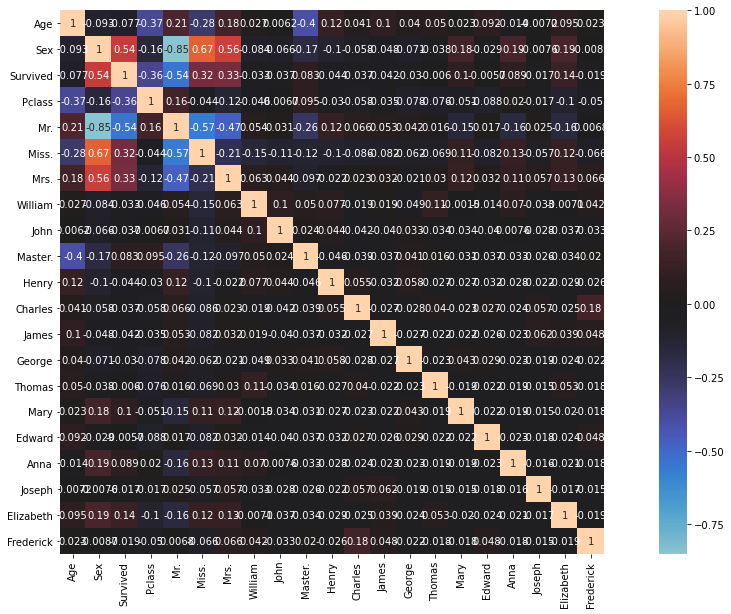

In [6]:
# 2.2 展示称谓特征及与性别和年龄的相关性（限于图的尺寸，仅展示16例）
isnaAge=train['Age'].isna()
mix_train=pd.concat(
    [   train[['Age','Sex','Survived','Pclass']] , train_name_words[words['key'].loc[:16]] ]
                       ,axis=1).loc[~isnaAge]
plt.figure(figsize=(20,10))
sns.heatmap(mix_train.corr(),square=True,annot=True,center = 0)

In [7]:
# 2.3 提炼出称谓特征 train_title 和 test_title
mix_train=pd.concat(
    [   train[['Age','Sex','Survived','Pclass']] , train_name_words ]
                       ,axis=1).loc[~isnaAge]
print(mix_train[["Sex", 'Mr.','Mrs.','Miss.','Master.','Mr','Mrs']].groupby("Sex").mean())
# 发现 'Mr.'和'Master.'总是男性；'Mrs.','Miss.'总是女性。但是有 Mr 为女性的应该是错误输入，但是没有关系，可以同化处理。
# 其余称谓或无称谓一律映射为0。
def to_title(title_matrix:pd.DataFrame):
    change_coefficient={'Mr.':1,'Mrs.':1,'Mr':1,'Mrs':1,'Miss.':2,'Master.':2}
    ret = pd.Series(np.zeros(shape=(title_matrix.shape[0],)),name='Title',dtype=float)
    for key,c in change_coefficient.items():
        ret.loc[title_matrix[key]>0] = c
    return ret
train['Title']=to_title(train_name_words)  # 注意 train_title 是 pandas.Series 不再是矩阵
test['Title']=to_title(test_name_words)

          Mr.      Mrs.     Miss.  Master.        Mr       Mrs
Sex                                                           
0    0.878587  0.000000  0.000000  0.07947  0.880795  0.000000
1    0.000000  0.413793  0.559387  0.00000  0.429119  0.429119


In [8]:
# 2.4 其余姓名特征降维处理
# 由于其他特征过于稀疏，需要降维压缩减少过拟合
# names_feather=pd.concat([train_name_words,test_name_words],axis=0).drop(['Mr.','Mrs.','Miss.','Master.'],axis=1)
# pca=PCA(n_components=0.6)   # 这些特征随机因素太大，所以保留的维度不能太多，否则容易过拟合
# train_namesF=pca.fit_transform(train_name_words.drop(['Mr.','Mrs.','Miss.','Master.'],axis=1),y=train[["Survived","Age"] ])
# test_namesF=pca.transform(test_name_words.drop(['Mr.','Mrs.','Miss.','Master.'],axis=1))

# 2.5 其余姓名特征使用卡方检验的filter过滤（不能直接检验连续型变量，需要离散化）
# train_titlesF=train_name_words.drop(['Mr.','Mrs.','Miss.','Master.','Mr','Mrs'],axis=1)
# chivalue,pvalue=chi2(train_titlesF,y=train["Survived"] )

In [9]:
# p_title=pd.Series(pvalue,index=train_titlesF.columns )
# print(p_title.loc[p_title<0.05])
# namesF=p_title.loc[p_title<0.05].index

In [10]:
#3.0 统计共用票的情况
t=train['Ticket'].unique()
print(train.shape,t.shape)  # 891个样本只有681个值
from collections import Counter
TicketCount=Counter(pd.concat([train['Ticket'],test['Ticket']],axis=0))
train['SameTicketsNum']=pd.Series(map(TicketCount.get,train['Ticket']))
test['SameTicketsNum']=pd.Series(map(TicketCount.get,test['Ticket']))

(891, 16) (681,)


In [45]:
# 4.1 筛选对于预测年龄有利的特征
age_clf=ReliefF(n_features_to_select=0.3,   # 筛选出多少个特征（或比例）
                n_neighbors=30             # 设 n_neighbors=K ，ReliefF 算法比较的K近邻数量
                )
# train.describe()
# 训练年龄预测模型
naAge_train=train['Age'].isna()
naAge_test=test['Age'].isna()
# 注意预测age不能使用Survived属性
ori_lable_for_age=['Pclass','Sex','Family_size','SibSp','Embarked','SameTicketsNum','LogFare','Title']
# 原始数据集去掉无意义和不可以使用的特征
age_X=pd.concat([train[ori_lable_for_age] ,
                     train_name_words.drop(['Mr.','Mrs.','Miss.','Master.','Mr','Mrs'],axis=1)
                 ],axis=1).loc[~naAge_train]
# naF=age_X.isnull().any(axis=0)
# print(naF.loc[naF])
age_Y=train['LogAge'].loc[~naAge_train]
# print(age_Y.isna().any())
age_clf.fit(X=age_X.values,y=age_Y.values)

Index(['Title', 'Pclass', 'LogFare', 'SameTicketsNum', 'Family_size', 'SibSp',
       'J', 'Embarked', 'Sex', 'y', 'A', 'H', 'E', 'Johan', 'de', 'George',
       'Henry', 'L', 'Frank', 'Patrick', 'John', 'Edward', 'Francis', 'Daniel',
       'Van', 'Thomas', 'William', 'O', 'Ernst', 'James', 'Elias', 'Bertram',
       'Andrew', 'Frederick', 'Alfred', 'Matilda', 'Ernest', 'Mary', 'Jensen',
       'Carter'],
      dtype='object')


In [64]:
age_importantF=age_X.columns[age_clf.top_features_[:18]]
print(age_importantF)
# 自定义构造出的 'Title' 对年龄的预测排在第一名

AgeTrainX=pd.concat([train , train_name_words],axis=1)[age_importantF]
AgeTrainY=train['LogAge'].loc[~naAge_train]   # 对年龄进行开方以提高低龄段的敏感度
# test数据集不能训练 Age预测器，只是用来检验 Age预测器的效果及其泛用性。
AgeTestX=pd.concat([test , test_name_words],axis=1)[age_importantF]
AgeTestY=test['LogAge'].loc[~naAge_test]


Index(['Title', 'Pclass', 'LogFare', 'SameTicketsNum', 'Family_size', 'SibSp',
       'J', 'Embarked', 'Sex', 'y', 'A', 'H', 'E', 'Johan', 'de', 'George',
       'Henry', 'L'],
      dtype='object')


In [65]:
from sklearn.model_selection import GridSearchCV
params={
    'eta':0.3,
    'gamma':0.1,    # == min_split_loss
    'n_estimators':200,
    'objective':'square',
    'max_depth':6,
    'learning_rate':0.1,
    'alpha':0.1,    # 因为特征比较稀疏，可以增加L1正则项达到LASSO回归的效果
    'min_child_weight':1,   # 对于回归问题，假设损失函数是均方误差函数，每个样本的二阶导数是一个常数，这个时候 min_child_weight就是这个叶子结点中样本的数目。如果这个值设置的太小，那么会出现单个样本成一个叶子结点的情况，这很容易过拟合。
}
cv_params = {
    'n_estimators': np.linspace(50, 71, 3, dtype=int),
    # 'gamma':np.linspace([0.0,0.5,0.05],dtype=float),
    'max_depth':np.linspace(5,7,2,dtype=int),
    # 'learning_rate':np.linspace([0.1,1.0,0.1],dtype=float),
    # 'alpha':np.linspace([0.0,1.0,0.1],dtype=float),
}
# python 语法，字典对象前加两个*可以转化成以key为参数名且对应value为参数值带入到方法参数列表中。
age_xgb=XGB.XGBClassifier(**params)
# age_xgb.fit(AgeTrainX.loc[~naAge_train],age_f(AgeTrainY))
gs = GridSearchCV(age_xgb, cv_params, verbose=2 ,scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
# # 仅使用 train 数据集（Age非空的样本）训练预测 Age 的模型
gs.fit(AgeTrainX.loc[~naAge_train],AgeTrainY)

# 对 test数据集（Age非空的样本）的Age进行预测
AgeTestAnsY=gs.predict(AgeTestX.loc[~naAge_test])
# 因为预测的是开方年龄，年龄不能为负，且要平方回去才对
# AgeTestAnsY= np.square(np.clip(AgeTestAnsY,a_min= 0,a_max= np.inf))

print("参数的最佳取值：:", gs.best_params_)
print("最佳模型得分:", gs.best_score_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   30.9s finished
C:\Users\java_lee\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:33:05] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
参数的最佳取值：: {'max_depth': 5, 'n_estimators': 60}
最佳模型得分: -0.28680417260531377


179.851221686747


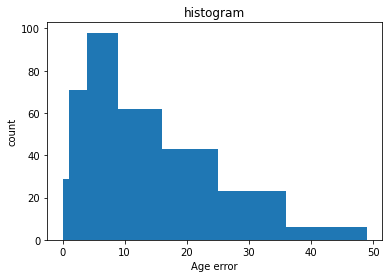

In [63]:
from sklearn.metrics import mean_squared_error # 均方误差
MSE= mean_squared_error(np.exp(AgeTestY),np.exp(AgeTestAnsY))
# MSE= mean_squared_error(AgeTestY,AgeTestAnsY)
print(MSE)
std_error_list=np.fabs(np.exp(AgeTestY)-np.exp(AgeTestAnsY))
# std_error_list=np.fabs(AgeTestY-AgeTestAnsY)
hist,AgeBins = np.histogram(std_error_list,bins = np.square(list(range(int(1.999+np.sqrt(std_error_list.max())) ))) )
plt.hist(std_error_list, bins =  AgeBins)
plt.xlabel("Age error")
plt.ylabel("count")
plt.title("histogram")
plt.show()

In [67]:
# 对 train和 test数据集中 Age缺失值进行预测并保存结果。
naAgeTrainX=AgeTrainX.loc[naAge_train]
train_ageP=pd.Series(gs.predict(naAgeTrainX),index=naAgeTrainX.index)
naAgeTestX=AgeTestX.loc[naAge_test]
test_ageP=pd.Series(gs.predict(naAgeTestX),index=naAgeTestX.index)

oriF=['Pclass','Sex','SibSp','Parch','Family_size','Embarked','LogAge','Title','SameTicketsNum']
train2=train[['Survived',]+oriF].copy()
train2['LogAge'].loc[naAge_train]=train_ageP

test2=test[oriF].copy()
test2['LogAge'].loc[naAge_test]=test_ageP   # 表示年龄是真实而非预测所得

train2.to_csv("./train2.csv")
test2.to_csv("./test2.csv")

C:\Users\java_lee\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
